# Filtering function
The segmentation routine identifies contiguous regions likely containing ice. We know from experience that it often has flagged regions that are not ice, and can be filtered using clues such as the floe circularity.

The purpose of this notebook is to develop a filtering function with tunable parameters. The main sections here are
1. Compile a list all the test cases with information on (a) whether each stage of IFT completed (b) on whether it's been assigned for floe labeling, and (c) whether the floe labels have been completed.
2. Read in the hdf5 files and true color images
3. Overlay the floe labels on the true color images. These are the "unfiltered" results
4. Filter the labeled images based on a set of thresholds

# 1. Making a list of cases where data is available

In [ ]:
import h5py
import pandas as pd
from os.path import join
from os import listdir
import numpy as np
from skimage.measure import regionprops_table
import rasterio as rio
from rasterio.plot import reshape_as_image
import proplot as pplt


caselist_loc = '../data/validation_tables/qualitative_assessment_tables/all_100km_cases.csv'
eval_table_loc = '../data/ift_data/ift_pipeline_default/eval_tables/'
assign_table_loc = '../data/validation_tables/floe_labeling_tables/'
label_floe_loc = '../data/validation_images/labeled_floes_png/'
image_loc = '../data/validation_images/'

df_cases = pd.read_csv(caselist_loc, index_col=0)

# this is to make it easier to link the filenames and case numbers
case_reference = pd.DataFrame({'case_number': df_cases.loc[df_cases.satellite=='aqua', 'case_number'].values,
                               'location': [x[4:] for x in df_cases.loc[df_cases.satellite=='aqua', 'long_name'].values]})

# this has the results on whether IFT ran to completion on each
df_eval = pd.concat([pd.read_csv(eval_table_loc + file) for file in listdir(eval_table_loc) if '.csv' in file])
df_eval['startdate'] = pd.to_datetime(df_eval['startdate'].values)
df_eval.reset_index(inplace=True, drop=True)
df_eval['region'] = [x.split('-100km')[0] for x in df_eval['location']]

# grabbing the assignments here so I know what folder to look in for un-reviewed floe labels
df_assign = pd.concat([pd.read_csv(assign_table_loc + file, index_col=0) for file in listdir(assign_table_loc) if '.csv' in file]) 
df_assign.reset_index(inplace=True, drop=True)

# this adds the case number to the evaluation files and pulls out the columns we need
df_merged = df_eval.merge(case_reference, left_on='location',
                          right_on='location').loc[:,
                                ['region', 'case_number', 'location',
                                 'startdate', 'enddate', 'preprocess']]
# add filenames for relevant images
df_merged['truecolor_aqua'] = ['_'.join([str(cn).zfill(3), region,
                                         '100km', start_date.strftime('%Y%m%d')]) + \
                                   '.aqua.truecolor.250m.tiff' for cn, region, start_date in zip(
                                        df_merged['case_number'],
                                        df_merged['region'],
                                        df_merged['startdate'])]
df_merged['falsecolor_aqua'] = [x.replace('true', 'false') for x in df_merged['truecolor_aqua']]
df_merged['truecolor_terra'] = [x.replace('aqua', 'terra') for x in df_merged['truecolor_aqua']]
df_merged['falsecolor_terra'] = [x.replace('aqua', 'terra') for x in df_merged['falsecolor_aqua']]

# add info on who was assigned the initial floe labeling
df_merged = df_merged.merge(df_assign.loc[:, ['case_number', 'fl_analyst']], left_on='case_number', right_on='case_number', how='outer')

# check if the floe labeling PNG has been created
labeled_floes = listdir(label_floe_loc)
df_merged['aqua_labeled_floes'] = False
df_merged['terra_labeled_floes'] = False
for idx, row in df_merged.iterrows():
    if row['truecolor_aqua'].split('.')[0].replace('_100km', '') + '_aqua_labeled_floes.png' in labeled_floes:
        df_merged.loc[idx, 'aqua_labeled_floes'] = True
    if row['truecolor_terra'].split('.')[0].replace('_100km', '') + '_terra_labeled_floes.png' in labeled_floes:
        df_merged.loc[idx, 'terra_labeled_floes'] = True
df_merged.set_index('case_number', inplace=True)
df_merged.sort_index(inplace=True)

In [94]:
df_temp = df_merged.loc[(df_merged.aqua_labeled_floes==True) | (df_merged.preprocess == 'pass'), ['region', 'fl_analyst', 'aqua_labeled_floes', 'terra_labeled_floes']]
print('Number of labeled images:', df_temp.aqua_labeled_floes.sum() + df_temp.terra_labeled_floes.sum())

Number of labeled images: 70


# 2. Loading HDF5 files and satellite images
Labeled images are stored in hdf5 files, while the satellite images are GeoTiffs.

In [66]:
experiment = 'ift_pipeline_minarea_100px'
tc_images = {}
fc_images = {}
floe_properties = {}
labeled_images = {}
indices = {}
for case_number in df_merged.loc[df_merged.preprocess=='pass'].index:
    region = df_merged.loc[case_number, 'region']
    case = df_merged.loc[case_number, 'location']
    dataloc = join('../data/ift_data/', experiment, 'ift_results', region, case)
    files = listdir(join(dataloc, 'preprocess', 'hdf5-files'))
    indices[case_number] = {}
    tc_images[case_number] = {}
    fc_images[case_number] = {}
    floe_properties[case_number] = {}
    labeled_images[case_number] = {}
    
    for file in files:
        if 'h5' in file:
            satellite = file.split('.')[1]
            ift_data = h5py.File(join(dataloc, 'preprocess', 'hdf5-files', file))
            indices[case_number]['x'] = ift_data['index']['x'][:]
            indices[case_number]['y'] = ift_data['index']['y'][:]
            # I load the props table here, but there's some issues with it 
            # so we'll re-calculate the props table later for now
            floe_properties[case_number][satellite] = pd.DataFrame(
                data=ift_data["floe_properties"]["properties"][:].T, # note the transposition
                columns=ift_data["floe_properties"]["column_names"][:].astype(str))
            labeled_images[case_number][satellite] = ift_data['floe_properties']['labeled_image'][:,:].T # note the transposition
            labeled_images[case_number][satellite] = np.ma.masked_array(
                labeled_images[case_number][satellite],
                mask=labeled_images[case_number][satellite]==0)
        else:
            print(case_number, 'no h5')
    if len(files) == 0:
        print(case_number, 'no files')
    for satellite in ['aqua', 'terra']:
        with rio.open(join(image_loc, 'truecolor', df_merged.loc[case_number, 'truecolor_' + satellite])) as im:
            tc_images[case_number][satellite] = im.read()
        with rio.open(join(image_loc, 'falsecolor', df_merged.loc[case_number, 'falsecolor_' + satellite])) as im:
            fc_images[case_number][satellite] = im.read()

# 3. Overlay original segementation on images

In [95]:
# Optional: Overlay the labeled image on the true color image
make_plots = False
if make_plots:
    for case_number in labeled_images:
        if 'terra' in labeled_images[case_number]:
            fig, axs = pplt.subplots(width=8, height=4, ncols=2)
            for ax, satellite in zip(axs, ['aqua', 'terra']):
                ax.imshow(reshape_as_image(tc_images[case_number][satellite]))
                ax.imshow(labeled_images[case_number][satellite] % 10, cmap='tokyo')
                ax.format(ltitle=satellite.title())
            axs.format(suptitle='Case ' + str(case_number) + ' (' + df_merged.loc[case_number, 'region'].replace('_', ' ').title() + ')')
            fig.save('../figures/' + experiment + '/overlaid_segmentation/' + str(case_number).zfill(3) + '_segmentation_results.png', dpi=300)
            pplt.close(fig)

Some very obvious errors that should not happen ever:
- Case 32. This one should've been an easy one for the algorithm -- lots of nice, clear floes. Labeled image contains floes that are inside of the land mask.
- Case 20. Not sure what happened here.
- Case 22. Very large segment, likely a cloud, with many holes in it.
- Case 24. Possible case of the land mask being returned as a floe.
    


# 4. Set up filter function

In [117]:
# Advantage of doing this with regionprops_table is that we already use regionprops_table in IFT,
# so there are minimal changes needed to put a filter directly into the code
def ift_filter(labeled_image,
               truecolor_image,
               falsecolor_image,
               min_area = 100,
               max_area = 90000,
               circ_threshold = 0.6,
               solidity_threshold = 0.8, # Ratio of area to convex area - measure of gaps. 
               tc_intensity_thresholds = (0, 0, 0), # No idea what the best numbers for these are! Also not sure if we want max or min. 0 means the threshold will always be exceeded.
               fc_intensity_thresholds = (0, 0, 0)): 
    """Filter function for use with the labeled image output from Ice Floe Tracker. The function uses the regionprops_table function from 
    scikit-image to compute metrics for labeled objects. Returns a filtered labeled image and a properties table with a columns
    'label', 'area', 'perimeter', 'solidity', 'tc_channel'[0-2], 'fc_channel'[0-2], and flag columns
    'area_flag', 'circularity_flag', 'solidity_flag', 'tc0_flag', 'tc1_flag', 'tc2_flag', 'fc0_flag', 'fc1_flag', 'fc2_flag', 'flagged'.
    The 'flagged' column is set to True if at least one of the flag columns is true. Flagged values failed at least one of the tests.
    """

    # other options: can look at intensity range, potentially also intensity standard deviation
    props = pd.DataFrame(regionprops_table(labeled_image, truecolor_image, properties=['label', 'area', 'perimeter', 'solidity', 'intensity_mean']))
    props_fc = pd.DataFrame(regionprops_table(labeled_image, falsecolor_image, properties=['label', 'intensity_mean']))
    
    props.rename({'intensity_mean-0': 'tc_channel0',
                  'intensity_mean-1': 'tc_channel1',
                  'intensity_mean-2': 'tc_channel2'}, axis=1, inplace=True)
    props_fc.rename({'intensity_mean-0': 'fc_channel0',
                     'intensity_mean-1': 'fc_channel1',
                     'intensity_mean-2': 'fc_channel2'}, axis=1, inplace=True)
    
    props = props.merge(props_fc, left_on='label', right_on='label')
    
    props['circularity'] = 4*np.pi*props['area']/props['perimeter']**2
    
    props['area_flag'] = (props['area'] <= min_area) & (props['area'] >= max_area)
    props['circularity_flag'] = props['circularity'] < circ_threshold
    props['solidity_flag'] = props['solidity'] < solidity_threshold
    for label, thresholds in zip(['tc', 'fc'], [tc_intensity_thresholds, fc_intensity_thresholds]):
        for channel in range(3):
            props[label + str(channel) + '_flag'] = props[label + '_channel' + str(channel)] < thresholds[channel]
    
    all_flags = ['area_flag', 'circularity_flag', 'solidity_flag', 'tc0_flag', 'tc1_flag', 'tc2_flag', 'fc0_flag', 'fc1_flag', 'fc2_flag']
    props['flagged'] = props.loc[:, all_flags].any(axis=1)

    filtered_image = labeled_image.data.copy()
    for label in props.loc[props['flagged'], 'label']:
        filtered_image[filtered_image == label] = 0

    return filtered_image, props

Example of running the filter

I've loaded the images into dictionaries. Rasterio uses a different order for image dimensions than does scikit, so I use the `reshape_as_image` function to reformat them. 
You'll note that the props table that comes back has the mean values for different parameters. If we are careful to separate testing and training data, we can set up optimization routines to use the mean values for true positives to identify the appropriate thresholds for the truecolor and falsecolor channels.

In [134]:

case_number = 110
satellite = 'aqua'
labeled_im = labeled_images[case_number][satellite].copy()
tc_im = reshape_as_image(tc_images[case_number][satellite])
fc_im = reshape_as_image(fc_images[case_number][satellite])
filtered_im, props = ift_filter(labeled_im, tc_im, fc_im)

props.head()

,label,area,perimeter,solidity,tc_channel0,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2,...,area_flag,circularity_flag,solidity_flag,tc0_flag,tc1_flag,tc2_flag,fc0_flag,fc1_flag,fc2_flag,flagged
0,1,828.0,115.597980,0.972973,229.001208,229.474638,229.153382,118.315217,236.396135,240.285024,...,False,False,False,False,False,False,False,False,False,False
1,2,20239.0,1808.780879,0.330422,216.477148,217.126933,217.901379,116.857453,227.689560,231.319630,...,False,True,True,False,False,False,False,False,False,True
2,3,216.0,53.213203,0.977376,228.726852,229.726852,231.726852,95.157407,235.768519,241.231481,...,False,False,False,False,False,False,False,False,False,False
3,4,247.0,57.556349,0.968627,226.157895,227.157895,229.157895,95.210526,233.348178,238.522267,...,False,False,False,False,False,False,False,False,False,False
4,5,147.0,46.627417,0.942308,225.680272,226.210884,225.945578,112.897959,233.959184,239.870748,...,False,False,False,False,False,False,False,False,False,False


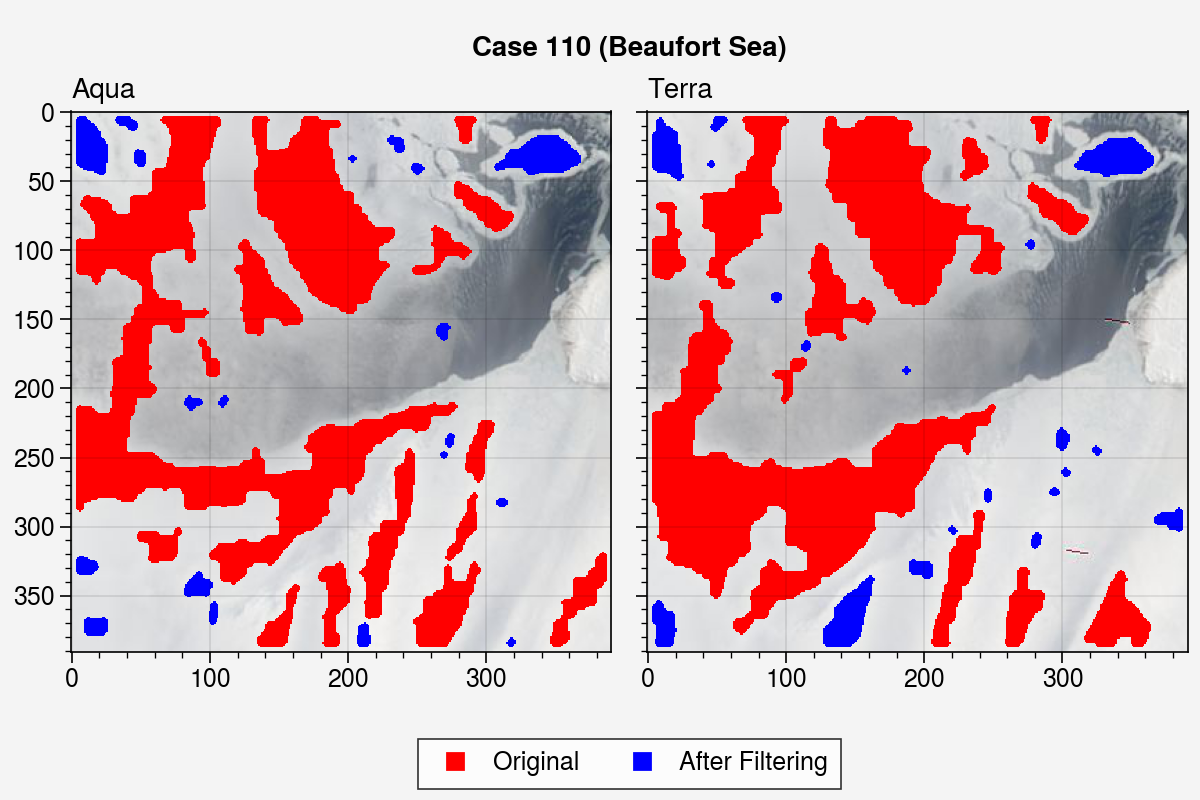

In [133]:
case_number = 110

fig, axs = pplt.subplots(width=6, height=4, ncols=2)
for ax, satellite in zip(axs, ['aqua', 'terra']):

    labeled_im = labeled_images[case_number][satellite].copy()
    tc_im = reshape_as_image(tc_images[case_number][satellite])
    fc_im = reshape_as_image(fc_images[case_number][satellite])
    filtered_im, props = ift_filter(labeled_im, tc_im, fc_im,
                                    circ_threshold = 0.6,
                                    solidity_threshold = 0.9)
     
    ax.imshow(reshape_as_image(tc_images[case_number][satellite]))
    ax.imshow(labeled_images[case_number][satellite], color='r')
    ax.imshow(np.ma.masked_array(filtered_im, filtered_im==0), color='b')
    ax.format(ltitle=satellite.title())
h = [ax.plot([],[], marker='s', lw=0, color=c) for c in ['r', 'b']]
l = ['Original', 'After Filtering']
fig.legend(h, l, loc='b', ncols=2)
axs.format(suptitle='Case ' + str(case_number) + ' (' + df_merged.loc[case_number, 'region'].replace('_', ' ').title() + ')')
